# Proximal Langevin Markov chain Monte Carlo algorithms

# Introduction

Modern imaging methods rely strongl on Bayesian inference techniques to solve challenging imaging problems. While Monte Carlo algorithms have turned into standard tools over the past decade, they still face difficulties in handling inference for high-dimensional models. One of the main problems encountered when using MCMC in this settings is that it is difficult to design a Markov chain that efficiently samples the state space of interest.

This paper presents a new and highly efficient Markov chain Monte Carlo methodology to perform Bayesian computation for high dimensional models that are log-concave and non-smooth, a class of models that is central in image processing. The methodology improves the Metropolis-adjusted Langevin algorithm MALA using convex optimisation algorithms and proximal operators enabling us to capture local properties of the target density and explore the parameter space efficiently.


### Note:
At the very end of the report, you will find an appendix section containing certain properties, demonstrations and proofs that we have chosen to omit from the main sections of the notebook for the sake of clarity and to ensure that the reader does not lose sight of the main idea of the article.


# Context

Most of the sampling techniques known so far do not scale to high-dimension and become impractible when the number of data samples is huge.
## log-concave distributions

In this report, we study sampling algorithms for sampling from a log-concave distribution.
We first introduce log-concave distributions, a class of probability distributions widely used in modern high dimensional statistics.
>#### Definition 
It is the class of all densities $\pi$ on $\mathbb{R}$ or on $\mathbb{R}^n$ that can be written as
$$\pi(x) = \frac{\exp^{g(x)}}{k}$$
Where $g$ is concave, and $k$ is the normalizing constant.

#### Assumptions:
$g: \mathbb{R}^n \to [0, +\infty)$  is a concave, upper semicontinuous function satisfying $\lim\limits_{\Vert x\Vert \rightarrow \infty} g(x) = - \infty$.
>#### Definition (Class of distribution $\mathcal{E}(\beta,\gamma)$)
We say that $\pi$ belongs to the one-dimensional class of distributions with
exponential tails $\mathcal{E}(\beta,\gamma)$ if for some $u$, and some constants
$\gamma> 0$ and $\beta > 0$, $\pi$ takes the form
$$\pi(x) \propto \exp(-\gamma |x|^{\beta}), ~~~~ |x|> u$$


## Geometric ergodicity
###  Geometric convergence of Metropolis chains

In this report, we will be brought to study geometric convergence properties of P-MALA. Indeed, some of the stability properties enjoyed by geometrically ergodic chains in simulation motivate our evaluations. We note, that such chains have central limit theorems and the like available, which makes it much easier to assess the algorithms.
Moreover, without geometric ergodicity algorithms will give rise to sample paths having 'heavy-tailed excursions' away from the centre of the distribution, leading to instability of estimating procedures.

>#### Definition (Total variation norm)
Let (X, $\mathcal{X}$) be a measurable space and let $\mu$, $\nu$  be two probability measures. The total variation norm between $\mu$ and $\nu$ noted $\Vert \mu-\nu\Vert_{TV}$, is defined by $$\Vert \mu-\nu\Vert_{TV} = 2 sup \{|\mu(f)-\nu(f)|:~f \text{ is measurable}, 0\leq f \leq 1\}$$

>#### Definition (Minorizing condition)
Let $P$ be a markov kernel on  $X\times\mathcal{X}$, and let $V:X\to[1,\infty[ $ a measurable function. For all $d>0$, there exists $\epsilon_d>0$ and a probability measure $\mu_d$ such that
$$ \forall x \in C_d :=\{V\leq d\}, ~~~~~~ P(x,.) \geq \epsilon_d \mu_d(.)$$ 





>#### Definition (Drift condition)
Let $V:X\to[1,\infty[ $ a measurable function. There exists a constant $(\lambda,b)\in(0,1)\times\mathbb{R}^+ $ such that $$ \forall x \in X, ~~~~~PV(x) \leq \lambda V(x) +b $$


>#### Definition (Geometric ergodicity)
Let $P$ be an irreductible aperiodic markov kernel on  $X\times\mathcal{X}$. Assume that both the minorizing and drift condition are satisfied for some measurable function
$V \geq 1$. Then there exists a constant $\rho \in (0,1)$ such that $\forall n \in \mathbb{N}$ and $\forall x,x'\in X$
$$ \Vert P^n(x,.) - P^n(x',.)\Vert_{TV} \leq \rho^n (V(x)+V(x'))$$

There are two conditions on the target density $\pi$, which essentially suffice to ensure geometric ergodicity:
+ First, the tails of $\pi$ need to be uniformly exponential or lighter. In one dimension this was essentially shown to be a necessary and sufficient condition.

+ In higher dimensions we need a second condition, requiring that $\pi$ behave sufficientlysmoothly in the tails. This is stated more precisely, as a curvature condition on the contours of the target density. 

## Langevin Markov chain Monte Carlo
#### Proposed method
Let $\pi$  denote a log-concave probability density function on $\mathbb{R}^n$, one from which it is desired to draw an ensemble of independent and identically distributed samples. To do so, we will first consider Langevin Markov chain Monte Carlo method.

The Metropolis-adjusted Langevin algorithm is a Markov chain Monte Carlo method for obtaining random samples from a probability distribution for which direct sampling is difficult. MALA uses a combination of two mechanisms to generate the states of a random walk that has the target probability distribution as an invariant measure:
+ Candidates are proposed using Langevin diffusion, which use information about the target density in the
form of the gradient of $\log\pi$.
+ The candidates are accepted or rejected using Metropolis–Hastings algorithm.

### Unadjusted Langevin Algorithm
Let $\pi$ be a probability distribution that is everywhere non-zero and differentiable so that $\nabla \mathrm{log} \pi $ is well-defined.

>#### Definition
Let $\pi$ be a probability distribution on $\mathbb{R}^n$. A process $Y(t)$ is a Langevin diffusion process on $\mathbb{R}^n$ that has $\pi$ as stationary distribution is the solution to the equation$$ dY(t) = \frac{1}{2} \mathrm{log}\pi(Y(t))dt + dW(t), \space Y(0) = y_0 $$where $W$ is the $n$-dimensional Brownian motion (see appendix for definition).

Under additional assumptions, this equation has a unique strong solution and converges in distribution to $\pi$ which makes it interesting for simulating from $\pi$.


In general, the above stochastic differential equation cannot be solved exactly and the below first-order Euler discretisation is used instead:

>#### Definition (Discrete-time approximation of the Langevin diffusion process)
The discrete-time approximation of the Langevin diffusion process with step size $\delta$ with a forward Euler approximation is the following process, also called ULA$$ L^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$The parameter $\delta$ controls the incrementation and the variance of the Gaussian pertutbation.

These approaches are interseting typically because of their convergence under certain stability conditions. ULA also presents a good approximation of $Y(t)$ and converges to en ergodic measure that is close to $\pi$.



### Metropolis Adjusted Langevin Algorithme
While ULA approximates $\pi$, the Metropolis Adjusted Langevin corrects the approximation error by introducing a rejection step that guarantees convergence to the correct target density $\pi$. In order to describe the approach, it is useful to outline the standard construction of the Hastings and Metropolis algorithms. To correct for first-order integration error that is introduced from the discretisation, we consider the above update rule as defining a proposal candidate :
 $$ \tilde{L}^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$
 

A Metropolis-Hastings acceptance probability is then calculated after a step. The algorithm accepts the candidate as the new state of the Markov chain with probability
$$ \alpha(L^m, \tilde{L}^{m+1} )= min(1, \frac{\pi(\tilde{L}^{(m+1)}) q(L^m| \tilde{L}^{(m+1)})}{  \pi(L^{m} )q(\tilde{L}^{(m+1)}|L^m)})$$
where
$q(x) \sim \mathcal{N}(  x + \frac{\delta}{2} \nabla \mathrm{log} \pi (x),~ \delta\mathbb{I}_n )$ is the proposal distribution, such that the transition probability density from $x$ to $x'$ is  $$q(x'|x) \propto \exp\left(- \frac{1}{2\delta} \Vert x' - x - \frac{\delta}{2} \nabla log \pi(x) \Vert^2 \right) $$ 
Otherwise, with probability equal to $1 −  \alpha(L^m, \tilde{L}^{m+1} )$, the chain stays at the same position.


>#### Algorithm 1: Metropolis adjusted Langevin algorithm (MALA)
>**Inuput:** n, step size
>
>**Output:** $L^1,..., L^n$
>
>**for** $m=1,...,n$  **do**
>
>  >Draw independently  $\tilde{L}^{(m+1)} \sim \mathcal{N}(  L^m + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^m),  ~\delta\mathbb{I}_n )$ and $U^{m+1} \sim Unif(0,1)$
> set $$
L^{m+1} = \left\{
    \begin{array}{ll}
        \tilde{L}^{m+1} & \mbox{if } U^{m+1} \leq \alpha(L^m, \tilde{L}^{m+1} )  \\
        L^m & \mbox{otherwise}
    \end{array}
\right.
$$
**end**

The Metropolis-Hastings step that underlies the MALA algorithm ensures that the resulting Markov chain has the correct stationary distribution. With this choice of $\alpha$ we have that $\pi$ is invariant: that is, satisfies $ \pi(A)=\int \pi(x)Q(x,A)\, \mathrm{d}x,~x\in, A\in$

Provided the chain is suitably irreducible and aperiodic, it
is then standard that the n-step transition probabilities, converge to $\pi$ in the total variation norm.
The purpose of the MetropolisHastings correction (2) is to ensure that the target density π is stationary for the Markov
chain.



In the next section of the notebook can be found an implementation of ULA and MALA.


# Implementation

In [1]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm
sns.set_style("whitegrid")

### Unadjusted Langevin Algorithm

In [2]:
def ULA(n_samples, initial_state, log_p, step_size):
    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        x += step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.multivariate_normal.rvs(size=d)
        samples[i,:] = x
  
    return samples

### Metropolis Adjusted Langevin Algorithm



In [3]:
def MALA(n_samples, initial_state, log_p, step_size):

    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    accepted = np.zeros(n_samples)
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        y = x + step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.norm.rvs(size=d)
        samples[i] = y
        log_q = lambda x, y : scs.norm.logpdf(y, x + step_size / 2 * grad_log_p(x), step_size * np.eye(d))

        if log_p(y) + log_q(y,x) - log_p(x) - log_q(x,y) < 0:
            y = x
            accepted[i] = 1
        else:
            accepted[i] = 0

    return samples, accepted

### Illustration (In 1D)

In [4]:
def log_gauss(mu, sigma):
    return lambda x : - ((x - mu) / sigma)**2 / 2 - np.log(sigma * np.sqrt(2 * np.pi))

log_quartic_dist = lambda x : - x**4

In [17]:
def hist_and_true_dens(samples, log_density, figname):
    x = np.linspace(min(samples), max(samples), len(samples))
    sns.histplot(samples, stat='density', legend=False)
    plt.plot(x, np.exp(log_density(x)), color='darkblue', label='Target density')
    plt.title(figname, fontsize=14)
    plt.legend()


def test_convergence_mean(samples_list, param_name, params, target_mean, ylim=[]):
    plt.figure(figsize=(8.0,5.0))
    if len(ylim) != 0:
        plt.ylim((ylim[0], ylim[1]))
    plt.axhline(target_mean, color="black", lw=2, label='Target mean')

    for k in range(len(params)):
        samples = samples_list[k]
        t = np.arange(1, len(samples) + 1)
        samples_sum = np.cumsum(samples) / t
        plt.plot(t, samples_sum,  lw=1.2, label=param_name+'='+str(params[k]))

    plt.legend()


def plot_accept_prob(accept_list, param_name, params):
    y = np.empty_like(params)
  
    for k in range(len(params)):
        accept = accept_list[k]
        y[k] = len(accept[accept == 1]) / len(accept)
  
    plt.figure(figsize=(7.2,4.5))
    plt.semilogy(params, y)
    plt.xlabel(param_name)
    plt.ylabel('Acceptance probability')

In [6]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([2])
step_size = 30
MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
MALA_samples_accepted = MALA_samples[accepted == 1]

To test our algorithm, we plotted some graphs wheren we compare a chosen target density and the result obtained by MALA. To do so, we overlay their histograms.

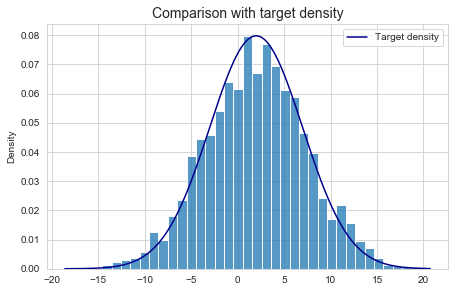

In [7]:
plt.figure(figsize=(7.2,4.5))
hist_and_true_dens(MALA_samples_accepted, log_p, "Comparison with target density")

Now let's try if our algorithm works as well as in the graph above for different step sizes.

In [8]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 300
x0 = np.array([5])
step_sizes = np.array([2, 10, 22, 35, 80])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])

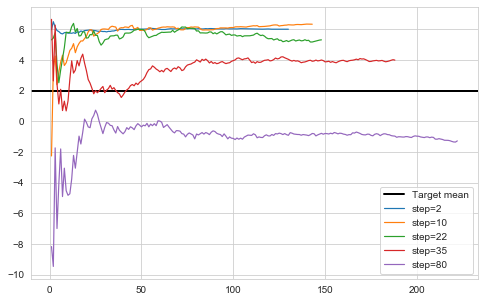

In [9]:
test_convergence_mean(MALA_samples_list,'step' ,step_sizes, 2, ylim=[])

We notice that there exists an optimal step size is $\approx 50$, for which the mean of the Markov chain obtained by MALA converges to the target density mean. When the step sizes are too small or too big these convergence properties diminish.

In [10]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([5])
step_sizes = np.linspace(1,100,10)
MALA_accept_list = []

for step_size in step_sizes:
    _, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_accept_list.append(accepted)

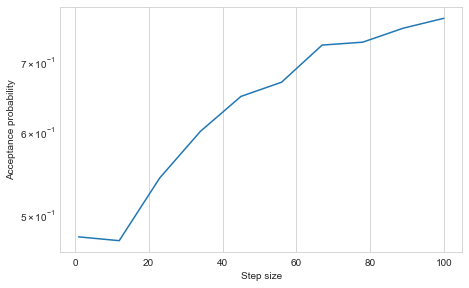

In [30]:
plot_accept_prob(MALA_accept_list, 'Step size', step_sizes)

We notice that as the step size gets bigger, the acceptance probability takes higher values. By analogy with the previous comment, the acceptance probability should not take extreme values, typically here what we would consider as the optimal intervall for the acceptance probability would be $[0.5, 0.7]$.
Thus, the choice of an optimal step size can be determined by the acceptance probability.

### Limitations of ULA and the Langevin MCMC
These approaches are unfortunately not very useful:

* The Langevin diffusion process $Y(t)$ is not easy to sample from in general, which makes it not very versatile.
- ULA can get transient in certain cases (especially when $\pi$ belongs to a certain class). Even with the addition of a Metropolis-Hastings rejection step to ensure convergence with MALA, geometric ergodicity is not always guarenteed (see Appendix for geometric ergodicity definition).
+ $\pi$ is required to be $\mathcal{C}^1$ for MALA to work, which limits the scope of the distributions we can approach.

We illustrate an adversarial example of these limitations bellow:

We condiser a density of $\mathcal{E}(\beta,\gamma)$ where $ \beta > 2$, we know that in this case the resulting Markov chain obtained by MALA is not geometrically ergodic ( as mentionned in the *Exponential convergence of Langevin distributions and their discrete approximations* paper by ROBERTS and TWEEDIE)

#### MALA Adversarial example

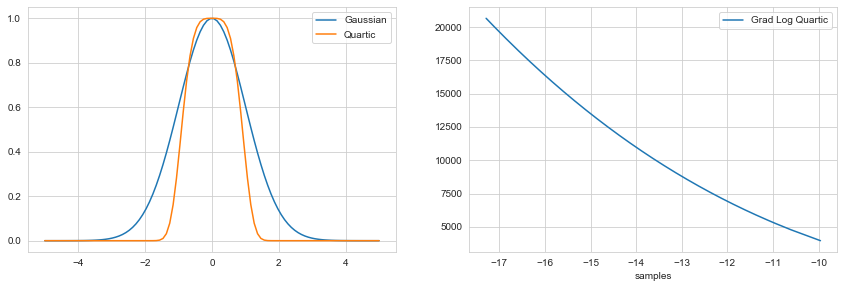

In [13]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(14.5,4.5))

plt.subplot(1,2,1)
plt.plot(x, np.exp(log_gauss(0,1)(x)) * np.sqrt(2 * np.pi), label='Gaussian')
plt.plot(x, np.exp(log_quartic_dist(x)), label='Quartic')
plt.legend()

log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_size = 1
MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
MALA_samples = MALA_samples[accepted == 1]

plt.subplot(1,2,2)
#plt.ylim((-10,10))
grad_q = grad(log_quartic_dist)
x = sorted(MALA_samples)
y = np.array([grad_q(x_j) for x_j in x])
plt.plot(x, y, label='Grad Log Quartic')
plt.xlabel('samples')
plt.legend()

+ **First graphic:** We can see that the tail of the Quartic distribution is lighter than the Gaussian distribution. Which makes it more difficult to sumilate where the quartic density has non null values

+ **Second graphic:** We notice that gradient log quartic takes big values, this can explain the behaviour of the resulting chain. Given the fact that the derivate of the log density increases very fast, no matter where we start from, we end up diverging.

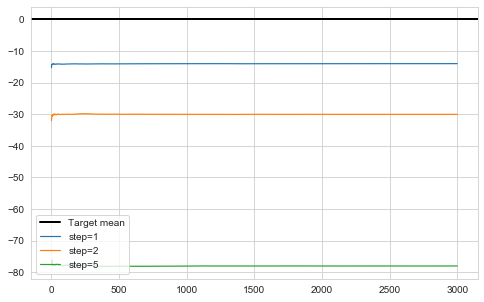

In [18]:
log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_sizes = np.array([1, 2, 5])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])

test_convergence_mean(MALA_samples_list,'step' ,step_sizes, 0, ylim=[])

In the figure above we try to illustrate the law of Large Numbers for chains obtained with different steps value.
Here we can see that no matter what step is used to simulate the chain, the chain diverges and this can be explained by the previous comment. We also explain the fact the mean is constant by the fact that the acceptance ratio is equal to 1.

## A proximal point of view


> #### Definition (Proximity mappings)
The $\lambda$-proximity mapping of a concave function $g$ is defined for any $\lambda>0$ as
$$ prox_g^{\lambda}(x) = \arg\max_{u\in\mathbb{R}^n}~~ g(u) - \frac{1}{2\lambda}\Vert u -x\Vert^2 $$

Similarly to gradient mappings, $prox_g^{\lambda}$ also moves points in the direction of the minimum of $g$.
>#### Definition (Moreau approximations)
For any $\lambda>0$, the $\lambda$-Moreau-Yosida envelope of $g$ is a carefully regularised approximation of $g$ given by
$$\pi_{\lambda}(x) = \sup_{u\in\mathbb{R}^n} \pi(u)\exp\left(-\frac{1}{2\lambda}\Vert u - x \Vert\right)/k'$$
where $k'\in \mathbb{R}^+$ is the normalizing constant.

One of the most interesting properties is the convergence of the Moreau approximation $\pi_{\lambda}$ towards $\pi$ when $\lambda$ to $0$. 

# When Moreau meets Langevin
The main idea is to replace the non-smooth $\pi$ with a carefully designed smooth approximation $\pi_{\lambda}$ which, by construction can be as close to $\pi$ as we want by adjusting the approximation parameter $\lambda>0$. 
Thus, if $\pi$ is not continuously differentiable, but the proximity operator associated
with $\pi$ is available, we can consider sampling algorithms that use the $\lambda$-Moreau-Yosida envelope $\pi_{\lambda}$ instead of $\pi$.

### Proximal unadjusted Langevin algorithm
We first approximate the Langevin diffusion $Y(t)$ by $Y_{\lambda}(t)$ defined as 

$$ dY_{\lambda}(t) = \frac{1}{2} \mathrm{log}\pi_{\lambda}(Y(t_{\lambda}))dt + dW(t), \space Y(0) = y_0 $$
such that  $Y_{\lambda}$ has an invariant measure $\pi_{\lambda}$

Since it is only possible to analytically solve the stochastic equation above in few specific cases, we consider a discrete-time Eumer-Maruyama approximation:
$$ Y^{(m+1)} = Y^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi_{\lambda} (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$
In an equivalent way using the fact that $\nabla \mathrm{log} \pi_{\lambda}(x) = (prox_g^{\lambda}(x)-x)/\lambda$ we obtain 
$$ Y^{(m+1)} = \left( 1-\frac{\delta}{2\lambda}\right)Y^{(m)} + \frac{\delta}{2\lambda} prox_g^{\lambda}( Y^{(m)}) +  \sqrt{\delta} Z^{(m)}$$
where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$
The parameter $\delta$ controls the incrementation and the variance of the Gaussian pertutbation as mentionned before.

The regularity properties of $\pi_{\lambda}$ will lead to discrete approximations with favourable stability and convergence properties. 
#### Selecting the optimal value for $\lambda$:
+ Since we want to simulate from $\pi$, considering the discrete approximation of a Langevin diffusion with invariant measure $\pi_{\lambda}$,  $\lambda$ should be set as small as possible to ensure that $\pi_{\lambda}$ is close to $\pi$.

+ From a convex optimisation viewpoint $\lambda$ should not be smaller than $\frac{\delta}{2}$

>#### Definition (P-ULA)
We define the optimal $\lambda$ as the smallest value within the set $[\frac{\delta}{2},\infty[$.
>
>By setting $\lambda = \frac{\delta}{2}$ we obtain the P-ULA Markov chain defined as :
$$  Y^{(m+1)} =  prox_g^{\lambda}( Y^{(m)}) +  \sqrt{\delta} Z^{(m)} $$ 
where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$

### Convergence of P-ULA

The convergence of the P-ULA will depend primarily on its geometric ergodicity. We will focus primarily now on the one-dimensional case. The extension to the high-dimensional case can be passed on through Property 5.

The article lists two intereseting results: the first is **Theorem 3.1** (whose proof is available in the Appendice):

#### Theorem 3.1:

> **If** 
* $\pi$ is one dimensional 
* $\forall x \in \mathbb{R}, \space \pi(x) = \frac{g(x)}{\kappa}$ where $g$ is an upper semicontinuous concave function
* For some $d > 0$:
$$
\left\{
    \begin{array}{l}
    S_d^+ = \mathrm{lim}_{x \rightarrow +\infty} \frac{prox_g^{\delta/2}(x) - x}{x^d} \\
    S_d^- = \mathrm{lim}_{x \rightarrow -\infty} \frac{prox_g^{\delta/2}(x) - x}{\vert x \vert^d}
    \end{array}
\right.
$$
* $ S_d^+ <0 $ and $ S_d^- > 0$ exist
>
> **Then** *P-ULA* is geometrically ergodic

The second result is the corolloary that is derived from the previous theorem, which is **Corollary 3.1**

#### Corollary 3.1:

> **If** $\pi \in \mathcal{E}(\gamma, \beta)$ and $\forall x \in \mathbb{R}, \space \pi(x) = \frac{\exp(g(x))}{\kappa}$ where $g$ is an upper semicontinuous concave function.
>
> **Then** *P-ULA* is geometrically ergodic

You can take a quick look at the proof inspired by the indications given in the paper behind this corollary in the appendix.

### Proximal Metropolis-adjusted Langevin algorithm
We introduce now the **Proximal Metropolis-Adjusted Langevin Algorithm**. The key difference between *P-MALA* and *P-ULA* is the introduction of an accept-reject step, the Metropolis-Hastings way. This step and the choice of the acceptance probability will make $(Y^{(m)})_m$ a Markov-Chain with invariant probability measure $\pi$.

To ensure this invariance, we will follow the following steps:
 * Let $Q$ be the kernel provided by the transition step of *P-ULA* algorithm, which gives us in our case: $Y^* \sim Q(X^{(m)}, .) =  \mathcal{N}(prox_g^{\delta/2}(X^{(m)}), \delta \mathbb{I}_n)$
 * We will denote $Q(x, du) = q(x,u)du$, we will simplify by using the Lebesgue-measure on $\mathbb{R}^n$
 * We will set the acceptange probability as the following:
 $$ r(x, u) = \mathrm{min}\left(1, \frac{\pi(u) q(x,u)}{\pi(u) q(u,x)}\right) $$
 * The previous probability measure verifies: $\space \pi(x)r(x, u)q(x, u) = \pi(u)r(u, x)q(u, x)$, which will ensure that the algorithm *P-MALA* is $\pi$-reversible and thus $\pi$-invariant. We also note that in this case, $r$ has also the benefit of being the highest acceptance probability for this algorithm.

We can then understand how the introduced steps give us a stronger guarentee of the convergence to $\pi$


>#### Algorithm : Proximal Metropolis adjusted Langevin algorithm (P-MALA)
>**Inuput:** n, step size
>
>**Output:** $X^0,X^1,..., X^n$
>
>Draw $X^0$ according to some arbitrary distribution
>
>**for** $m=1,...,n$  **do**
>  >Draw independently $\mathcal{N}(prox_g^{\delta/2}(X^{(m)}), \delta \mathbb{I}_n)$ and $U^{m} \sim Unif(0,1)$
>>
>> set $$
X^m = \left\{
    \begin{array}{ll}
        Y^* & \mbox{if } U^{m} \leq \alpha(X^m, Y^* )  \\
        X^m & \mbox{otherwise}
    \end{array}
\right.
$$
>
>**end**


### Convergence of P-MALA:

#### Theorem 3.3
>Let $A(x) = \{u : r(x, u) = 1\}$ be the acceptance region of P-MALA from point
$x$, and $I(x) = \{u : x\geq u\}$ the region of points interior
to $x$. Suppose that $A$ converges inwards in $q$, i.e.
$$lim_{\Vert x\Vert \to \infty }\int_{A(x)\Delta(x)} q(u|x) \, \mathrm{d}u = 0 $$ 
Where $A(x)\Delta(x)$ denotes the symmetric difference $ A(x)\cup I(x)/A(x)\cap I(x)$. Then P-MALA is geometrically ergodic.

#### Theorem 3.2
>Suppose that $\pi \in \mathcal{C}^2$ and that (1) holds. Then
there exists a continuous-extension $\bar{Y}(t)$ of the P-ULA chain for which 
$$ \lim_{\delta \to 0} \mathbb{E}\left( \sup_{0\leq t\leq T} |\bar{Y}(t)-Y(t)|^2 \right)= 0$$
where $Y (t)$ is the Langevin diffusion with ergodic measure $\pi$. Moreover, if $\nabla log\pi $ is polynomial in $x$, then P-ULA converges strongly to $Y (t)$ at optimal rate; that is
$$\mathbb{E}\left( \sup_{0\leq t\leq T} |\bar{Y}(t)-Y(t)|^2 \right)= O(\delta)$$

# Implementation
Using proximal mappins for non differentiable and log-concave target densities

In [24]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm
import scipy.io as sio
import random
from scipy.sparse import coo_matrix
import time
sns.set_style("whitegrid")

## P-MALA

In [19]:
def pmala(X0=None,g=None,proxg=None,options=None):
    
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
    n = X0.shape # gives num of rows and cols of X0
    Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 
  #print(Xchain.shape)
    gTrace = np.zeros(int(options['samples'] * options['thinning']))  
    acceptTrace = np.zeros(int(options['samples'] * options['thinning'])) 

  # Initialize variables
    delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
    lamda = options['lambda']
    Xcur = X0               # set initial state as current state
    proxgXcur = proxg(Xcur,lamda)    # pre-compute proxg(Xcur)
    gXcur=g(Xcur)              # pre-compute g(Xcur)
    gTrace[0]=gXcur             # record value g(Xcur) as a scalar summary
    if n[1]==1:
        Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
    else:
        Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # Set the appropriate norm for 'X'
    if n[1]==1:
        p = 2      # L2 norm (X is in vector form)
    else:
        p = 'fro'  # Frobenius (X is in matrix form)
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #   progressbar

    time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
    for ii in range(1, int(options['samples'] * options['thinning'])):
        # Generate candidate using P-ULA proposal
        if lamda == delta / 2:
            Xnew = proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1])
        else:
            Xnew = (1 - delta / (2*lamda)) * Xcur + (delta / (2*lamda)) * proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1])
    
    # Compute Metropolis-Hastings ratio: target ratio
        gXnew = g(Xnew)
        logPiRatio = gXnew - gXcur
    # Compute Metropolis-Hastings ratio: proposal ratio
        proxgXnex = proxg(Xnew,delta/2)
        logPropRatio = (np.linalg.norm(Xnew - proxgXcur,p)**2 - np.linalg.norm(Xcur - proxgXnex,p)**2)/(2*delta);
    
    # Accept-Reject candidate
        if np.log(np.random.rand(1)) < (logPiRatio + logPropRatio):
            Xcur = Xnew;                # set candidate as new current
            acceptTrace[ii]=1               # record that the candidate was accepted
            proxgXcur = proxgXnex           # record proxg(Xnew) for next iteration
            gXcur = gXnew              # record g(Xnew) for next iteration
    # Record value g(Xcur) as a scalar summary
        gTrace[ii] = gXcur
    
    # Record sample (with thinning)
        if not np.mod(ii,options['thinning']):
            if n[1]==1:
                Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
            else:
                Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    # Adapt the value of delta to achieve an appropriate acceptance rate (only during burn-in period)
        if options['updateDelta']:
            if ii < options['burnIn']*options['thinning']:
                if not np.mod(ii,options['updateDelta']):
          # Estimate acceptance probability over the last
          # 'options.updateDelta' iterations
                    accRate = np.mean(acceptTrace[int(ii-options['updateDelta']): int(ii)])
                
          # If accRate is 1% higher than targetRate increase delta
          # by 25%, otherwise if 1% lower decrease by 20%.
                    if accRate>options['targetRate']*1.01:
                        delta = delta*1.25
                        lamda = delta / 2
                    elif accRate<options['targetRate']/1.01:
                        delta = delta*0.8
                        lamda = delta / 2

    
    time_s = time.time()-time_start
    return Xchain,gTrace,acceptTrace,time_s,delta

#### Illustration
According to the **Corollary 3.2** of the article, if the target density $\pi \in \mathcal{E}(\beta, \gamma)$ then P-MALA is geometrically ergodic $\forall \delta >0$. In this part, we illustrate this result for log-concave densities of this family. 
Despite the fact that P-ULA and P-MALA are defined with $\lambda = \delta/2$, we give some illustrations with different values of $\lambda$ in order to prove that as said in theory the best choice is $\lambda = \delta/2$.

##### Simulate from univariate Laplace distribution

To begin let's try to simulate from a density that is not differentiable. That's one of the purpose of P-MALA by using proximal operators. Here we simulate from an univariate Laplace distribution. Its density is in general defined as : $\frac{1}{2b}\exp(-\frac{\lvert x-\mu \rvert}{b})$ where $\mu \in \mathbb{R}$ and $b>0$

In [21]:
# Define g = \log\pi(x)
def g1(X):
    return -np.abs(X)
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))

In [22]:
# Sampler setup
def def_options(samples, thinning, delta, lamda, display, targetRate, updateDelta, burnIn):
    options = {}
    options['samples'] = samples # total number of samples
    options['thinning'] = thinning # thinning factor (i.e., iterations per sample)
    options['delta'] = delta # value of time-discretisation step "delta"
    options['lambda'] = lamda
    options['display'] = display # do not display progressbar
    options['targetRate'] = targetRate # target an acceptance probability of around 60%
    options['updateDelta'] = updateDelta # adjust the value of delta every ... iterations
    options['burnIn'] = burnIn # adjust the value of delta only during the first ... iterations
  
    return options

In [25]:
options = def_options(samples=5e3, thinning=1, delta=5, lamda=3, display=0, targetRate=0.6, 
                      updateDelta=0, burnIn=0)

X0 = np.random.rand(1, 1)
lamdas = [0.5, 3, 10, 50]
PMALA_samples_list = []

for lamda in lamdas:
    options['lambda'] = lamda
    PMALA_samples, _, accepted, _, delta = pmala(X0,g1,proxg1,options)
    PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])
    PMALA_samples_list.append(PMALA_samples[accepted == 1])

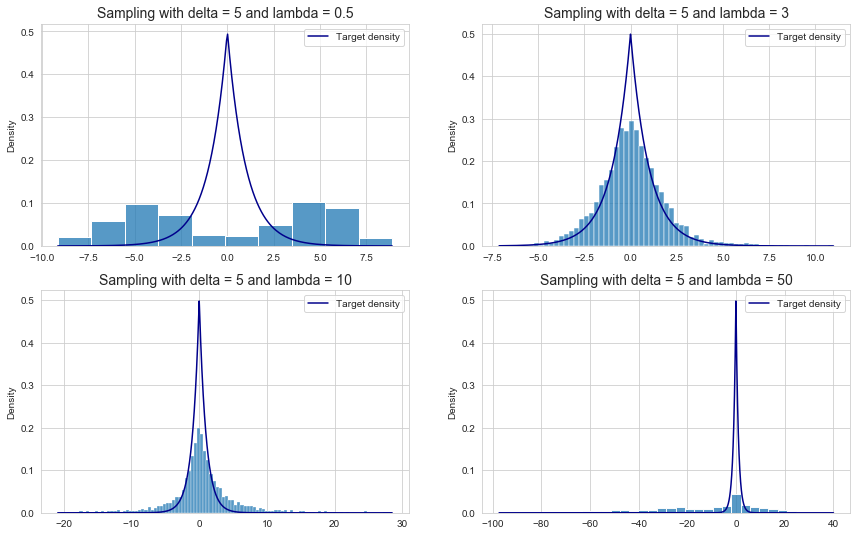

In [26]:
log_p = lambda x : g1(x) - np.log(2)

plt.figure(figsize=(14.5,9))

for i in range(1,len(PMALA_samples_list)+1):
    plt.subplot(2,2,i)
    hist_and_true_dens(PMALA_samples_list[i-1], log_p, "Sampling with delta = {0} and lambda = {1}".format(delta,lamdas[i-1]))

As we can see on the graphs above, when $\lambda=\delta/2$ the Markov chain produced by P-MALA is ergodic and the stationnary distribution is a good approximation of the Laplace distribution. We also remark that when $\lambda$ is too big or too small ($\ll \delta/2$), the Markov chain produced is explosive and does not converge to the target distribution.

In [27]:
options = def_options(samples=1e4, thinning=1, delta=5, lamda=2.5, display=0, targetRate=0.6, 
                      updateDelta=20, burnIn=1e4)

X0 = np.random.rand(1, 1)
target_rates = [0.3, 0.45, 0.55, 0.65, 0.85]
PMALA_samples_list = []

for rate in target_rates:
    options['targetRate'] = rate
    PMALA_samples, _, accepted, _, _ = pmala(X0,g1,proxg1,options)
    PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])
    PMALA_samples_list.append(PMALA_samples[accepted == 1])

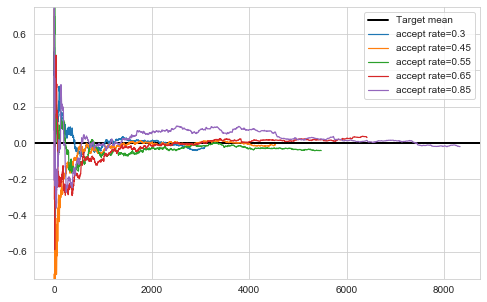

In [28]:
test_convergence_mean(PMALA_samples_list,'accept rate' ,target_rates, 0, ylim=[-0.75,0.75])

Here, we set $\lambda$ to $\delta/2$ and use the law of large numbers to see how fast the chains produced converge in function of the acceptance rate and inderectly the step size $\delta$. We can then see on the graph just above that no matter the acceptance rate is low or high the law of large numbers works well. That being said, when the acceptance rate is in the interval $[45\%,65\%]$ the convergence seems to be faster.

##### Simulate from univariate Quartic distribution

Let's now try to simulate from an univariate Quartic distribution. Previously, we proved numericaly that MALA is not geometrically ergodic for this type of distributions. More generally for densities of the family $\mathcal{E}(\beta, \gamma)$ with $\beta>2$, MALA is not geometrically ergodic (as proven in *Roberts and Tweedie 1996*). Below, we prove that P-MALA is geomtrically ergodic in this case.

The expression of target density we consider here is $\pi(x) \propto \exp(-x^4)$. The mean of the associated distribution is $0$. Here in order to compare the histogram of the samples with the target density, we compute the normalization constant with the function `quad` from `scipy.integrate`.

In [29]:
# Define g = \log\pi(x)
def g3(X):
    return -pow(X,4)
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
    p = 1.0/(4.*lamda)
    q = 1.0*X/(4.*lamda)
    w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
    w = w3 ** (1/3)
    u = p/(3.*w) - w
    return u

In [30]:
from scipy.integrate import quad

quartic_p = lambda x : np.exp(- x**4)
const = quad(quartic_p, -np.inf, np.inf)[0] # compute normalisation constant

In [31]:
options = def_options(samples=1e4, thinning=1, delta=1, lamda=0.75, display=0, targetRate=0.6, 
                      updateDelta=0, burnIn=1e4)
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
PMALA_samples, _, accepted, _, delta = pmala(X0,g3,proxg3,options)
PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])

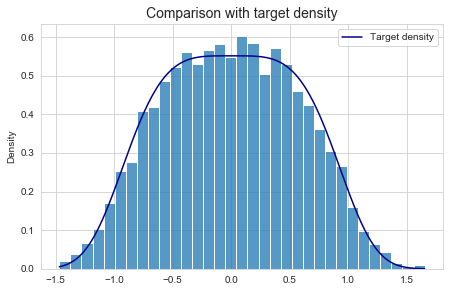

In [32]:
PMALA_samples_accepted = PMALA_samples[accepted == 1]
log_p = lambda x : g3(x) - np.log(const)
plt.figure(figsize=(7.2,4.5))
hist_and_true_dens(PMALA_samples_accepted, log_p, "Comparison with target density")

Clearly, according to the graph above the Markov chain produced by P-MALA is ergodic and the stationnary distribution seems to be a good approximation of the Quartic distribution. 

We can now try to see why P-MALA works in this case and not MALA. An idea is to see the values taken by the proximity mappings.

Text(0.5, 1.0, 'Proximity mappings')

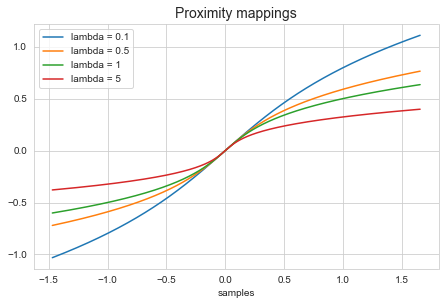

In [33]:
plt.figure(figsize=(7.25,4.5))

lamdas = [0.1, 0.5, 1, 5]
x = sorted(PMALA_samples_accepted)

for i in range(1,len(lamdas)+1):
    y = np.array([proxg3(x_j, lamdas[i-1]) for x_j in x])
    plt.plot(x, y, label="lambda = {0}".format(lamdas[i-1]))

plt.xlabel('samples')
plt.legend()
plt.title("Proximity mappings",fontsize=14)

We can see that the proximity mappings are not explosive for the values taken by the samples. Indeed, since $\operatorname{prox}^{\lambda}_{g}(x)$ converges to the identity function when $\lambda \rightarrow 0$, when the step size is well chosen the markov chain won't explose and explore zones we don't want it to. 

# Appendix 

This section is dedicated to the demonstrations and various proofs that we have tried to do, there are also some properties and results that we have preferred to omit from the main section for the sake of clarity.

#### Properties of the Moreau approximation

We will now list a number of properties that characterize the Moreau-approximation.

The proofs of the following properties (except for Property 6, which we are going to admit) are available in the Appendice, led by the instructions described in the article (we also exhibit a different approach for Property 1).
* **Property 1: Convergence**

$\pi_{\lambda}$ converges to $\pi$ pointwise when $\lambda \rightarrow 0$ i.e: $\forall x \in \mathbb{R}^n, \space \mathrm{lim}_{\lambda \rightarrow 0} \pi_{\lambda}(x) = \pi(x)$.
* **Property 2: Differentiability** 

$\pi_{\lambda}$ is continuously differentiable even if $\pi$ is not. In this case, $\forall x \in \mathbb{R}^n: \space \nabla \mathrm{log}\pi_{\lambda}(prox_g^{\lambda}(x)) = \frac{(prox_g^{\lambda}(x) - x)}{\lambda}$
* **Property 3: Subdifferential**

$\forall x \in \mathbb{R}^n, \space \frac{(prox_g^{\lambda}(x) - x)}{\lambda} \in \partial \mathrm{log}(prox_g^{\lambda}(x))$. In addition, if log$\pi$ is differentiable at prox$_g^{\lambda}(x)$, then: $\nabla \mathrm{log}\pi(prox_g^{\lambda}(x)) = \frac{(prox_g^{\lambda}(x) - x)}{\lambda}$
* **Property 4: Maximimzers**
$$
\left \{
    \begin{array}{l}
        \{\mathrm{argmax}_{u \in \mathbb{R}^n}\pi(u) \} = \{ \mathrm{argmax}_{u \in \mathbb{R}^n}\pi_{\lambda}(u)  \} \\
        \nabla \mathrm{log} \pi_{\lambda}(x^*) = 0 \implies x^* \in \{\mathrm{argmax}_{u \in \mathbb{R}^n}\pi(u) \}
    \end{array}
\right.
$$

* **Property 5: Seperability**

**If:**
$$
\left \{
    \begin{array}{l}
        \forall x=(x_1,..,x_n) \in \mathbb{R}^n, \space \pi(x) = \prod_{i=1}^n f_i(x_i) \\
        \forall i \in \{1,..,n\}, \space {f_i}_{\lambda}(x) = \mathrm{sup}_{u_i \in \mathbb{R}} \frac{f_i(u) \mathrm{exp}(- \frac{( u_i - x_i)^2}{2\lambda})}{\kappa'^{\frac{1}{n}}}
    \end{array}
\right.
$$
**Then** $\forall x=(x_1,..,x_n) \in \mathbb{R}^n, \space \pi_{\lambda}(x) = \prod_{i=1}^n {f_i}_{\lambda}(x_i)$
* **Property 6: Exponential Tails**

**If** $\pi \in \mathcal{E}(\gamma, \beta)$ with $\beta \geq 1$

**Then** $\pi_{\lambda} \in \mathcal{E}(\gamma', \beta')$ for some $\gamma' > 0$ and $\beta' = \mathrm{min}(\beta, 2)$

These properties justify the use of the Moeau-approximation in this case and present a number of characteristics that will be used further in our report (and in the article).


## Proofs of the Moreau approximation properties

**1 - Point-wise convergence:**

The idea here is to imagine that when $\lambda \rightarrow 0$, it will behave as a Dirac mass around $x$. Let's explore another approach that helps us visualize this Dirac mass in a different way.

Let $x \in \mathbb{R}^n$ an aribitrary point and  $\lambda_0 > 0: \pi_{\lambda_0}(x) = \mathrm{sup}_{u \in \mathbb{R}^n} \frac{\pi(u)\mathrm{exp}({-\frac{\Vert u - x\Vert^2}{2\lambda_0}})}{\kappa'} $

Since $\log$ is increasing and continuous, we can consider this form instead:
$$ \mathrm{log}\pi_{\lambda_0}(x) = \mathrm{sup}_{u \in \mathbb{R}^n}(g(u) - \frac{\Vert u - x \Vert^2}{2\lambda_0} - \mathrm{log}(\kappa \kappa'))$$

We can ignore the $- \mathrm{log}(\kappa \kappa')$ for the time being because it doesn't affect the process.

We have 
$$\begin{equation}
\left\{ 
  \begin{aligned}
    \mathrm{lim}_{\Vert u \Vert \rightarrow + \infty} g(u) = - \infty  \\\
    \mathrm{lim}_{\Vert u \Vert \rightarrow + \infty} - \frac{\Vert u - x \Vert^2}{2\lambda_0} = - \infty  \\
  \end{aligned}
  \right.
\end{equation}
$$
Then we can consider $\epsilon > 0$ s.t $ \exists \space \alpha > 0 $ which verifies:
$$
\forall u \notin \overline{\mathcal{B}}(\mathbf{0_n}, \Vert x \Vert + \alpha): g(u) - \frac{\Vert u - x \Vert^2}{2\lambda_0} < \mathrm{log} \pi_{\lambda_0}(x) - \epsilon
$$
$\overline{\mathcal{B}}(\mathbf{0_n}, \Vert x \Vert + \alpha)$ being a compact set and $g$ being an upper semi-continuous function, we can say that $g - \frac{\Vert . - x \Vert^2}{2\lambda_0}$ is bounded on this set. Let's then define $M > 0$ s.t:
$$
\forall u \in \overline{\mathcal{B}}(\mathbf{0_n}, \Vert x \Vert + \alpha) : -M \leq g(u) - \frac{\Vert u - x \Vert^2}{2\lambda_0} \leq M
$$
and denote $-A = \mathrm{min}(-M, \mathrm{log}\pi_{\lambda_0}(x) - \epsilon)$

In paricular we have $ -A \leq g(x)$

Let $\lambda > 0 $ , $\forall u \in \mathbb{R}^n $ s.t $ \Vert u - x \Vert > 2\sqrt{\lambda A}$ :
$$- \frac{\Vert u - x \Vert ^2}{2\lambda} < -2A$$
$$\Leftrightarrow g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda} < -A$$
$$\implies g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda} < g(x) \leq \mathrm{sup}_{v \in \mathbb{R}^n} (g(v) - \frac{\Vert v - x \Vert ^2}{2\lambda})$$

We can then safely say that
$$\mathrm{sup}_{u \in \mathbb{R}^n} (g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda}) = \mathrm{sup}_{u \in \overline{\mathcal{B}}(\mathbf{0_n}, 2\sqrt{\lambda A})} (g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda})$$
When $\lambda \rightarrow 0: \space \overline{\mathcal{B}}(\mathbf{0_n}, 2\sqrt{\lambda A}) \rightarrow \{ x \} $

As a consequence,  $\space \mathrm{sup}_{u \in \overline{\mathcal{B}}(\mathbf{0_n}, 2\sqrt{\lambda A})} (g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda}) \rightarrow g(x) $

Which means, $\space \mathrm{sup}_{v \in \mathbb{R}^n} (g(u) - \frac{\Vert u - x \Vert ^2}{2\lambda} - \mathrm{log}(\kappa \kappa')) \rightarrow g(x) - \mathrm{log}(\kappa \kappa')$

And finally, using the continuity of $\exp$, 
$$ \mathrm{lim}_{\lambda \rightarrow 0} \pi_{\lambda}(x) = \pi (x) $$

**2 - Differentiability:**

As the author did, we refer to section 2.3 of Combettes and Wajs (2005) for this proof. For our case, the Moreau envelope of index $\lambda$ of the function $-g$ which is a lower semi-continuous convex function on $\mathbb{R}^n$. We get then:
$$\lambda_{-g} : \mathbb{R}^n \rightarrow \mathbb{R}: x \mapsto \mathrm{inf}_{u \in \mathbb{R}^n} -g(u) + \frac{\Vert u - x \Vert ^2}{2\lambda} $$
which equals $- \mathrm{log}\pi_{\lambda}$ up to an additive constant ($\mathrm{log}(\kappa')$ which we're not trying to evaluate).

Using the Lemma 2.5 in this same section, we get that $\lambda_{-g}$ is differentiable (more precisely, *FrÃ©chet-differentiable*) on $\mathbb{R}^n$. Using the differnetiability of $exp$ on $\mathbb{R}$ we can then say that $\pi_{\lambda}$ is differentiable on $\mathbb{R}^n$. Using the same lemma, we get that $\nabla \mathrm{log}\pi_{\lambda} = - \nabla \lambda_{-g} = \frac{(prox_{g}^{\lambda} - Id)}{\lambda}$

**3 - Subdifferential:**

We have by defnition: 
$$prox_g^{\lambda}(x) = \mathrm{argmax}_{u \in \mathbb{R}^n} \mathrm{log}\pi(u) - \frac{\Vert u - x \Vert^2}{2\lambda}$$

From section 2.3 of Combettes and Wajs (2005), we have that 
$$x - prox_g^{\lambda}(x) \in \partial \lambda(-g(prox_g^{\lambda}(x))$$
$$\implies \frac{x - prox_g^{\lambda}(x)}{\lambda} \in \partial \mathrm{log}\pi(prox_g^{\lambda}(x))$$
When $\mathrm{log}\pi$ is differentiable, $\partial \mathrm{log}\pi(prox_g^{\lambda}(x)) = \{ \nabla \mathrm{log}\pi(prox_g^{\lambda}(x))\}$ which gives the equality.

**4 - Maximizers:**

$x^*$ is a maximizer of $\pi_{\lambda}$ **iff** it is a maximizer of $\mathrm{log}\pi_{\lambda}$

Property 2 results in $\nabla \mathrm{log}\pi_{\lambda} = 0$ and as a consequence $prox_g^{\lambda}(x^*) = x^*$

Property 3 gives us then: $0 \in \partial \mathrm{log}\pi(prox_g^{\lambda}(x^*)) = \partial \mathrm{log}\pi(x^*)$. Then $x$ is a maximizer of $\pi$ (Fermat's rule).

**5 - Seperability:**

We have
$$\pi(x) = \prod_{i=1}^{n}f_i(x_i) \space ; \space \forall i \in \{ 1,..,n\}, {f_i}_{\lambda} = \mathrm{sup}_{u \in \mathbb{R}^n} (f_i(u) \frac{\mathrm{exp}\frac{\Vert u - x \Vert^2}{2\lambda}}{\kappa'})$$

We also have:
$$\forall x \in \mathbb{R}^n, \space prox_g^{\lambda}(x) = \mathrm{argmax}_{u \in \mathbb{R}^n} (g(u) - \frac{\Vert u - x \Vert^2}{2\lambda}) $$

$$\Leftrightarrow \forall x \in \mathbb{R}^n, \space prox_g^{\lambda}(x) = \mathrm{argmax}_{u \in \mathbb{R}^n} (\sum_{i=1}^n (\mathrm{log} f_i(x_i) - \frac{\vert u_i - x_i \vert^2}{2\lambda})) $$

$$\Leftrightarrow \forall x \in \mathbb{R}^n, \space prox_g^{\lambda}(x) = (prox_{\mathrm{log}f_1}^{\lambda}(x_1), .., prox_{\mathrm{log}f_1}^{\lambda}(x_n)) $$

Then we have $\forall x \in \mathbb{R}^n$:
$$\mathrm{log}\pi_{\lambda}(x) = g(prox_g^{\lambda}(x)) - \frac{\Vert prox_g^{\lambda}(x) - x \Vert^2}{2\lambda}$$

$$\Leftrightarrow \mathrm{log}\pi_{\lambda}(x) = \sum_{i=1}^n (\mathrm{log}f_i(prox_{\mathrm{log}f_i}^{\lambda}(x_i)) - \frac{\vert prox_{\mathrm{log}f_i}^{\lambda}(x_i) - x_i \vert^2}{2\lambda}) $$

$$\Leftrightarrow \mathrm{log}\pi_{\lambda}(x) = \sum_{i=1}^n \mathrm{log}{f_i}_{\lambda}(x_i)$$
$$\Leftrightarrow \pi_{\lambda}(x) = \prod_{i=1}^n {f_i}_{\lambda}(x_i)$$

**6 - Exponential Tails:**

We will admit this property.

### Convergence of P-ULA:

#### Proof of Corollary 3.1:

> We start from $\pi \in \mathcal{E} (\beta, \gamma)$ and $\pi(x) = \frac{\mathrm{exp}(g(x))}{\kappa}$
>
> Since $\pi$ is log-concave, $\beta > 1$ (otherwise it's impossible). Property 6 implies then that $\pi_{\delta/2} \in \mathcal{E}(\beta ', \gamma ')$ with $\beta ' = \mathrm{min}(\beta, 2)$ and for some $\gamma ' > 0 $.
>
> Which results in, for some $u > 0$:
>
>$$ \forall \vert x \vert > u, \space \mathrm{log} \pi_{\delta / 2} (x) =  - \gamma ' \vert x \vert ^{\beta '} + c'; \space c' \in \mathbb{R}$$
>
>$$ \forall \vert x \vert > u, \space \frac{d}{dx} \mathrm{log} \pi_{\delta / 2} (x) = -\gamma ' \beta ' \vert x \vert ^{\beta ' - 1 }$$
>
>From Property 2 we get that:
>
>$$ \forall \vert x \vert > u, \space \frac{ prox_g^{\delta/2}(x) - x }{\delta} = - \mathrm{sg}(x)\gamma ' \beta ' \vert x \vert ^{\beta ' - 1 } $$ 
>
>$$ \forall \vert x \vert > u, \space  - \frac{\vert prox_g^{\delta/2}(x) - x \vert ^2}{\delta \vert x \vert ^2} = \gamma \vert prox_g^{\delta/2}(x) \vert ^{\beta - 2} - \gamma' $$
>
>Then, for $d = \beta ' - 1 \in [0, 1]$ we get $\forall \delta > 0$:
>
>$$ S_d^+ = \mathrm{lim}_{x \rightarrow +\infty} (prox_g^{\delta/2}(x) - x)x^{1-\beta'} = -\gamma' \beta' \delta < 0 $$ 
>
>$$ S_d^- = \mathrm{lim}_{x \rightarrow -\infty} (prox_g^{\delta/2}(x) - x)\vert x \vert ^{1-\beta'} = \gamma' \beta' \delta > 0 $$
>
>This provides us with the necessary conditions to apply **Theorem 3.1**

### Convergence of P-MALA:

#### Theorem 3.3
>Let $A(x) = {u : r(x, u) = 1}$ be the acceptance region of P-MALA from point
$x$, and $I(x) = {u : x\geq u}$ the region of points interior
to $x$. Suppose that $A$ converges inwards in $q$, i.e.
$$lim_{\Vert x\Vert \to \infty }\int_{A(x)\Delta(x)} q(u|x) \, \mathrm{d}u = 0 $$ 
Where $A(x)\Delta(x)$ denotes the symmetric difference $ A(x)\cup I(x)/A(x)\cap I(x)$. Then P-MALA is geometrically ergodic.

#### Theorem 3.2
>Suppose that $\pi \in \mathcal{C}^2$ and that (1) holds. Then
there exists a continuous-extension $\bar{Y}(t)$ of the P-ULA chain for which 
$$ \lim_{\delta \to 0} \mathbb{E}\left( \sup_{0\leq t\leq T} |\bar{Y}(t)-Y(t)|^2 \right)= 0$$
where $Y (t)$ is the Langevin diffusion with ergodic measure $\pi$. Moreover, if $\nabla log\pi $ is polynomial in $x$, then P-ULA converges strongly to $Y (t)$ at optimal rate; that is
$$\mathbb{E}\left( \sup_{0\leq t\leq T} |\bar{Y}(t)-Y(t)|^2 \right)= O(\delta)$$
#### *Proof of Theorem 3.2:*

Hypotheses: $\pi \in \mathcal{C}^2$ and $\pi(x) = \frac{e^{g(x)}}{\kappa} \forall x \in \mathbb{R}^n$.

We use Property 3 since $\mathrm{log}\pi$ is differentiable which gives us: $\frac{\mathrm{prox}_{g}^{\delta / 2}(x) - x}{\lambda} = \nabla \mathrm{log} \pi (\mathrm{prox}_{g}^{\delta / 2}(x))$

Then, for the *split-step backward Euler* approximation of the Langevin diffusion $Y(t)$ using (9) we get:
$$ Y^{(m+1)} = Y^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (\mathrm{prox}_{g}^{\delta / 2}(Y^{(m)})) + \sqrt{\delta} Z^{(m)}, \space Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$

When referring to *Higham et al. (2003)*, we set the steps as follows, starting with the Stochastic Differential Equation:

$$ dY(t) = f(Y(t))dt + h(Y(t))dW(t)$$

where $W$ is the n-dimansional Brownian motion and 

$$ f(x) = \frac{1}{2} \nabla \mathrm{log} \pi (x) \space ; \space h(x) = 1 \space ; \space \forall x \in \mathbb{R}^n $$

We have that $f$ and $h$ in this case are in $\mathcal{C}^1$ ( $\pi$ is differentiable ). We also we have, since $g$ is concave:

$$ \forall a,b \in \mathbb{R}^n: \langle a - b, f(a) - f(b) \rangle = \frac{1}{2} \langle a - b, \nabla g( a) - \nabla g (b) \rangle$$
$$ \implies  \forall a,b \in \mathbb{R}^n: \langle a - b, f(a) - f(b) \rangle = 
\frac{1}{2} ( \langle a - b, \nabla g(a) \rangle - \langle a - b, \nabla g(b) \rangle )$$
$$ \implies  \forall a,b \in \mathbb{R}^n: \langle a - b, f(a) - f(b) \rangle \leq 
\frac{1}{2} ( (g(a) - g(b)) - \langle a - b, \nabla g(b) \rangle )$$
$$ \implies  \forall a,b \in \mathbb{R}^n: \langle a - b, f(a) - f(b) \rangle \leq 
\frac{1}{2} ( (g(a) - g(b)) + (g(b) - g(a)) ) = 0$$

which provides us with the assumtion (3.1) of *Higham et al. (2003)*. We add this to the *SSBE* we have already established and we apply the **Theorem 3.3** of *Higham et al. (2003)* to get the needed result!

For the second part of the theorem, we suppose that $\nabla \mathrm{log} \pi$ is polynomial in $x$. We will then admit having *Assumption 4.1* of *Higham et al. (2003)* which states that, when translated to our case:

$$ \exists D \geq 0, q \in \mathbb{N}, \forall a, b \in \mathbb{R}^n: \Vert  \nabla g(a) -  \nabla g(b) \Vert \leq 2D (1 + \Vert a \Vert^q + \Vert b \Vert^q) \Vert a - b \Vert ^2$$

Having already verified *Assumption 3.1*, we can then apply **Theorem 4.7** of the same reference, which yields the wanted result.